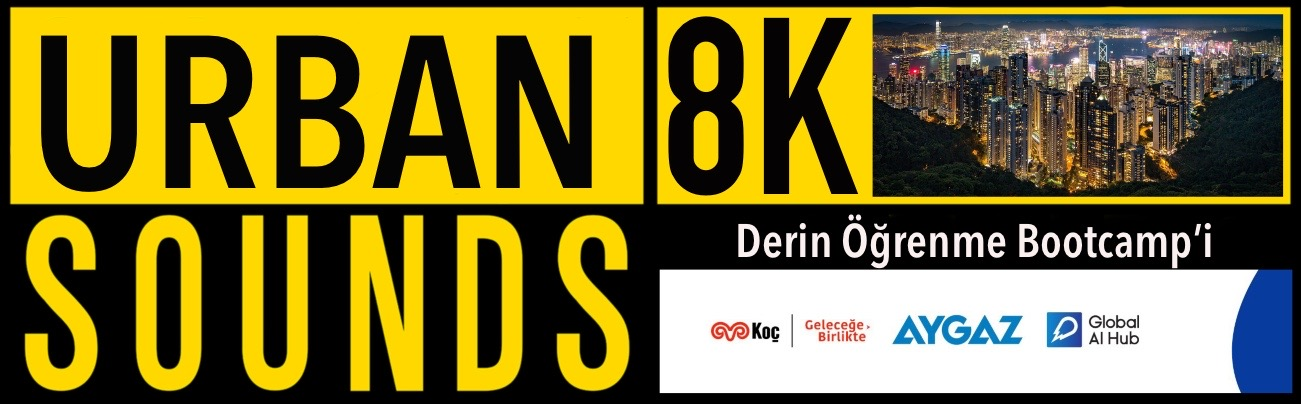


# <font color=orange>**Urban Sounds Classification**</font>

### <font color=gray>**Veri Seti Hikayesi**</font>

Bu proje “UrbanSounds8K” veri setini kullanarak şehirlerde duyulan seslerin sınıflandırılmasıyla ilgili bir projedir.
Bu projede hedefimiz, derin öğrenme algoritmalarını kullanarak yapay zeka modeli hazırlamaktır. 

Veri setine ait ses dosyalarından hazır olarak oluşturulmuş ve sınıflarına göre klasörlenmiş spectrogram görüntüler kullanılacaktır.
Bu notebookta görüntülere önişleme yapılacak ve CNN modeli için hazır hale getirilecektir.


<font color=salmon>**DATASET**</font>


Urbansound8K adlı bir veri seti, 10 sınıftan kentsel seslerin 8732 ses alıntısı şeklindeki spectrogramlardan oluşmaktadır.


<font color=gray>**Sınıflar**</font>

* **0 :** Air Conditioner
* **1 :** Car Horn
* **2 :** Children Playing
* **3 :** Dog bark
* **4 :** Drilling
* **5 :** Engine Idling
* **6 :** Gun Shot
* **7 :** Jackhammer
* **8 :** Siren
* **9 :** Street Music

### <font color=gray>**Kütüphanelerin Yüklenmesi**</font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from glob import glob
import cv2 as cv
from google.colab import files
from google.colab import drive 
from sklearn.model_selection import train_test_split

### <font color=gray>**Veri Setinin Yüklenmesi & Keşifçi Veri Analizi**</font>

In [ ]:
drive.mount('/content/drive/')
metadata=pd.read_csv('/content/drive/MyDrive/GAIH_Project/UrbanSound8K.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
# Tabloyu biraz düzenleme ve inceleme işlemleri
df=metadata.copy() #yedek alalım

In [ ]:
df.drop(['fsID','start','end','salience','fold'],axis=1,inplace=True)

In [ ]:
#Ses dosya adlarını görüntü dosya adları ile değiştirelim:
df=df.rename(columns={'slice_file_name':'spect_name'})

#ses dosya uzantılarını '.wav', görüntülere ait uzantı olan '.png' ile değiştirelim:
df.spect_name=df.spect_name.str.replace('.wav','.png')


In [ ]:
df.head()

,spect_name,classID,class
0,100032-3-0-0.png,3,dog_bark
1,100263-2-0-117.png,2,children_playing
2,100263-2-0-121.png,2,children_playing
3,100263-2-0-126.png,2,children_playing
4,100263-2-0-137.png,2,children_playing


In [ ]:
#Veri setinin yapısal bilgileri:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   spect_name  8732 non-null   object
 1   classID     8732 non-null   int64 
 2   class       8732 non-null   object
dtypes: int64(1), object(2)
memory usage: 204.8+ KB


In [ ]:
#sınıflara ait dosya sayıları:
df['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

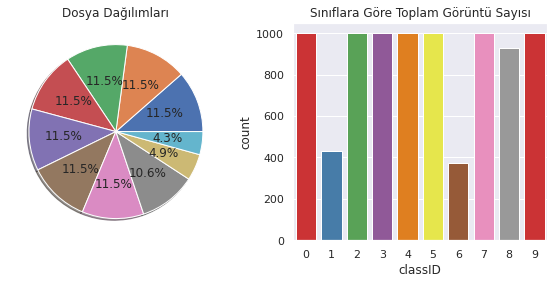

In [ ]:
#@title
fig,axes=plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
count=df['class'].value_counts()

plt.pie(count,autopct='%1.1f%%',shadow=True)
plt.title('Dosya Dağılımları')

plt.subplot(122)
(sns.countplot(data=df,x='classID',palette='Set1').
 set_title('Sınıflara Göre Toplam Görüntü Sayısı'));
sns.set_theme(style='darkgrid')
plt.show()


### <font color=gray>**Veri Önişleme**</font>

In [ ]:
spects_path=glob('/content/drive/MyDrive/GAIH_Project/spectrograms/*/*')

spectrograms=[]
labels=[]

for dosya in spects_path:
  spect=cv.imread(dosya) #görüntüleri okuma
  spect=cv.cvtColor(spect, cv.COLOR_BGR2GRAY) #görüntülere grayscale uygulama
  spect=cv.resize(spect,(64,64),interpolation=cv.INTER_AREA) 
  #yeniden boyutlandırma. (Küçültme yaptığımız için enterpolasyon inter_area tercih edilir.)
  spect=spect/255.0 #normalizasyon uygulama
  spectrograms.append(spect) #spectrograms listesine görüntüler eklenir.
  '''
  13230-0-0-1.png görüntülerin isim formatı incelendiğinde metadata içinde gelen
  'FREESOUNDCREDITS.txt' görüldüğü üzere soldan sağa ilk sayı kümesi 'soundid'
  yani sesi kaydeden bireyin id sini temsil ediyor. Örn; [13230]  by [Incarnadine].
  Ondan sonra gelen karakter dosyanın sınıfını temsil ediyor.
  Bu bilgiyi kullanarak bölümleme yapıp etiket olarak kullanalım.
  '-' ile parçalara ayırıp 2. elemanı seçelim.
  '''
  label=dosya.split('-')[1]
  labels.append(int(label))


* **[<font color=orange>goruntu,etiket</font>] formatında listenin oluşturulması:**

In [ ]:
#Görüntüler ve ait oldukları etiketleri [goruntu,etiket] formatında listeye atama:
liste=list(zip(spectrograms,labels))

#listeler hazır ancak hepsi şuan sıralı ve düzenli bir şekilde. Bu listeyi shuffle() komutu ile 
#yeniden düzenlenmiş liste olarak döndürme işlemi yapalım.
random.shuffle(liste)

#zip(*list) kullanımı:
'''
images=['img1','img2','img3', ...]
labels=['siren','gun_shot','dog_bark',...]
result=zip(images,labels)
print(list(results))

Output: [('img1','siren'),('img2','gun_shot'),('img3','dog_bark'),...]
'''
spectrograms,labels=zip(*liste)

#Create the features and the labels datasets
X=np.array(spectrograms).astype('float32')
y=np.array(labels)


### <font color=gray>**Train,Val ve Test Split İşlemleri**</font>


In [ ]:
X_train,X_temporary,y_train,y_temporary=train_test_split(X,y,
                                                         train_size=.8)

#X_temporary ve y_temporary veri kümesini kullanarak doğrulama ve test veri kümeleri oluşturma:
X_val,X_test,y_val,y_test=train_test_split(X_temporary,y_temporary,
                                           test_size=.5)

### <font color=gray>**Train,Val ve Test Veri Setlerinin Kayıt Edilmesi**</font>


In [ ]:
#Kayıt işlemleri için numpy kütüphanesinin np.save('file',arr) metodunu uygulama:
#Dosyalarımızı yeni oluşturacağımız için dosya sonuna '.npy' eklemek gerekiyor.

np.save('/content/drive/MyDrive/GAIH_Project/veriSetleri/X_train.npy',X_train)
np.save('/content/drive/MyDrive/GAIH_Project/veriSetleri/X_test.npy',X_test)
np.save('/content/drive/MyDrive/GAIH_Project/veriSetleri/X_val.npy',X_val)
np.save('/content/drive/MyDrive/GAIH_Project/veriSetleri/y_train.npy',y_train)
np.save('/content/drive/MyDrive/GAIH_Project/veriSetleri/y_test.npy',y_test)
np.save('/content/drive/MyDrive/GAIH_Project/veriSetleri/y_val.npy',y_val)

#Kayıt edilen dosyaları açmak için de np.load('file') 